# Elastic Rod Model

In [4]:
from IPython.display import display, Markdown
import random
def latexify(x):
    out = '$' + x + '$'
    return out

def lprint(x):
    display(Markdown(latexify(latex(x))))
    
%run -i 'implicit.py'

In this notebook a discretisation of the elastic rod bifurcation problem will be investigated

here we consider rods connected by elastic joints that resist angular perturbation, with a forcing action attempting to squash the rod

In [5]:
var('x')

lprint(arcsin(x))

$ \arcsin\left(x\right) $

In [6]:
def get_funcs(n):
    # returns a set of equations to solve

    var_dict = {}
    for i in range(0,n):
        # theta is the angle from the horizontal the ith line branches from
        var_dict['theta{}'.format(i)] = var('theta{}'.format(i), latex_name = r'\theta_{}'.format(i))
        
    var_dict['theta{}'.format(n)] = 0 # will update
        
    # compute the last theta, since must have the endpoints both zero on the vertical
    for i in range(0,n):
        var_dict['theta{}'.format(n)] = var_dict['theta{}'.format(n)] - sin(var_dict['theta{}'.format(i)])
        
    var_dict['theta{}'.format(n)] = arcsin(var_dict['theta{}'.format(n)])
    
    var_dict['l'] = var('l', latex_name=r'\lambda') # compressive force
   
    
    funcs = []
    energy = 0
    for j in range(1,n+1):
        # iterate through each spring in the rod
        e_spring = (var_dict['theta{}'.format(j-1)] + var_dict['theta{}'.format(j)])^2 
        # since pi - (pi - theta0 - theta1) e.g
        energy = energy + e_spring
        
    hoz = 0
    for i in range(0,n+1):
        # total horizontal extension
        hoz = hoz + cos(var_dict['theta{}'.format(i)])
           
    # take away the work done by the force
    energy = energy - var_dict['l']*(n + 1 - hoz)
            
    # solutions will be local minima of the energy equation
    for j in range(0,n):
        #don't care about the last angle
        funcs.append(energy.diff(var_dict['theta{}'.format(j)]))
        
    del var_dict['theta{}'.format(n)] # this was just a latent variable
        
    return funcs, var_dict
    

In [7]:
funcs, var_dict = get_funcs(2)

In [8]:
var_dict

{'theta0': theta0, 'theta1': theta1, 'l': l}

In [9]:
lprint(funcs)

$ \left[-{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_0}\right)\right)} {\lambda} - \frac{2 \, {\left({\theta_1} + \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 2 \, {\theta_0} + 2 \, {\theta_1}, -{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_1}\right)\right)} {\lambda} - 2 \, {\left({\theta_1} + \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} {\left(\frac{\cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} - 1\right)} + 2 \, {\theta_0} + 2 \, {\theta_1}\right] $

In [10]:
lprint(funcs[1](l,0,0))

$ 0 $

See that we have trivial solutions

In [11]:
old_var = var_dict
var_dict = {key : var_dict[key] for key in var_dict.keys() if var_dict[key] != 0}
var_dict = {key : var_dict[key] for key in var_dict.keys() if key != 'l'}

J = jacobian(funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(J)

$ \left(\begin{array}{rr}
-2 \, {\lambda} + 4 & -{\lambda} + 2 \\
-{\lambda} + 2 & -2 \, {\lambda} + 2
\end{array}\right) $

In [12]:
lprint(det(matrix(J))) # potential bifurcation point

$ 4 \, {\left({\lambda} - 1\right)} {\left({\lambda} - 2\right)} - {\left({\lambda} - 2\right)}^{2} $

In [13]:
lprint(solve(det(matrix(J)), l))

$ \left[{\lambda} = \left(\frac{2}{3}\right), {\lambda} = 2\right] $

We see there are two different force strenghts that seem to produce bifurcations

Suggest bifurcations at $\lambda = \frac{2}{3}$ and $\lambda = 2$

In [14]:
#bif_funcs = [func(l = 2/((32*sqrt(2)) + 36)) for func in funcs] #
#bif_funcs = [func(l = (sqrt(2)*(9/4))/((225*sqrt(2))/2 + 108)) for func in funcs] #
bif_funcs = [func(l = 2/3) for func in funcs]
#var_dict['l'] = old_var['l']
J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()})

lprint(J)

$ \left(\begin{array}{rr}
\frac{8}{3} & \frac{4}{3} \\
\frac{4}{3} & \frac{2}{3}
\end{array}\right) $

In [15]:
lprint(det(matrix(J.rows()[0:6])))

$ 0 $

### Orthogonalising the kernel

In [16]:
K = J.right_kernel().basis()
lprint(K)

$ \left[\left(1,\,-2\right)\right] $

In [17]:
Kperp = matrix(K).right_kernel().basis()
lprint(Kperp)

$ \left[\left(1,\,\frac{1}{2}\right)\right] $

In [18]:
A = matrix(K+Kperp).inverse().apply_map(lambda x: x.full_simplify())
lprint(A)

$ \left(\begin{array}{rr}
\frac{1}{5} & \frac{4}{5} \\
-\frac{2}{5} & \frac{2}{5}
\end{array}\right) $

In [19]:
key_list = [str(var) for var in var_dict.values()]
value_list = list(A*vector(var_dict.values()))
mutate_dict = dict(zip(key_list, value_list))

In [20]:
mutate_dict

{'theta0': 1/5*theta0 + 4/5*theta1, 'theta1': -2/5*theta0 + 2/5*theta1}

In [21]:
Afuncs = [func(**mutate_dict) for func in bif_funcs]

In [22]:
#lprint(Afuncs) 

In [23]:
Ja = jacobian(Afuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(Ja)

$ \left(\begin{array}{rr}
0 & \frac{8}{3} \\
0 & \frac{4}{3}
\end{array}\right) $

In [24]:
Ka = Ja(l=0).right_kernel().basis()
lprint(Ka)

$ \left[\left(1,\,0\right)\right] $

### Orthogonalising the image

In [25]:
I = Ja.image().basis()
I = [Ja*vec for vec in I]
print(len(I))

1


In [26]:
Iperp = matrix(I).right_kernel().basis()
lprint(Iperp)

$ \left[\left(1,\,-2\right)\right] $

In [27]:
B = matrix(I + Iperp).inverse().apply_map(lambda x: x.full_simplify())
lprint(B)

$ \left(\begin{array}{rr}
\frac{3}{10} & \frac{1}{5} \\
\frac{3}{20} & -\frac{2}{5}
\end{array}\right) $

In [28]:
tfuncs = vector(Afuncs)*B

In [29]:
#lprint(tfuncs)

In [30]:
Jt = jacobian(tfuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())

In [31]:
var_dict.values()

dict_values([theta0, theta1])

In [32]:
lprint(Jt)

$ \left(\begin{array}{rr}
0 & 1 \\
0 & 0
\end{array}\right) $

In [33]:
It = Jt.image().basis()
It = [Jt*vec for vec in It]
lprint(It)

$ \left[\left(1,\,0\right)\right] $

## Adding lambda back in

In [34]:
tfuncs = vector([func(**mutate_dict)(l = l + 2/3) for func in funcs])*B # now lambda is not fixed at the bifurcation point
# ***IF SOMETHING IS BROKEN CHECK RIGHT LAMBDA HERE***
# but we do shift so that l=0 is the new bifurcation
var_dict['l'] = l

In [35]:
var_dict_old = var_dict
var_dict_old

{'theta0': theta0, 'theta1': theta1, 'l': l}

In [36]:
var_dict.values()

dict_values([theta0, theta1, l])

In [37]:
lprint(tfuncs[1])

$ -\frac{1}{15} \, {\left(\frac{{\left(\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)} \cos\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right)}{\sqrt{-{\left(\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)}^{2} + 1}} + \sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right)\right)} {\left(3 \, {\lambda} + 2\right)} + \frac{2}{15} \, {\left(\frac{{\left(\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)} \cos\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)}{\sqrt{-{\left(\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)}^{2} + 1}} + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)} {\left(3 \, {\lambda} + 2\right)} - \frac{4}{25} \, {\left(2 \, {\theta_0} - 2 \, {\theta_1} - 5 \, \arcsin\left(-\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) - \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)\right)} {\left(\frac{\cos\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)}{\sqrt{-{\left(\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)}^{2} + 1}} - 1\right)} + \frac{2 \, {\left(2 \, {\theta_0} - 2 \, {\theta_1} - 5 \, \arcsin\left(-\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) - \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)\right)} \cos\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right)}{25 \, \sqrt{-{\left(\sin\left(\frac{1}{5} \, {\theta_0} + \frac{4}{5} \, {\theta_1}\right) + \sin\left(-\frac{2}{5} \, {\theta_0} + \frac{2}{5} \, {\theta_1}\right)\right)}^{2} + 1}} + \frac{2}{25} \, {\theta_0} - \frac{12}{25} \, {\theta_1} $

## Running the implicit function theorem

In [38]:
len(tfuncs)

2

In [39]:
position = {key : 0 for key in var_dict_old.keys()}
position

{'theta0': 0, 'theta1': 0, 'l': 0}

In [40]:
#code_funcs = [tfuncs[index].function(*list(var_dict_old.values())) for index in [0,1,2,3,4,5,6]] # careful with computer science indexing from zero
code_funcs = [tfuncs[index] for index in [0]] # the last function has degenerate first derivative always
position = {key : 0 for key in var_dict_old.keys()}
# var_dict already loaded
var_dict = {'y1' : theta1, 'x1' : l, 'x2' : theta0}
x_var_keys = ['l', 'theta0'] # the variables in the kernel
x_dim = 2
y_dim = 1 # invertible part

In [41]:
var_dict.keys()

dict_keys(['y1', 'x1', 'x2'])

In [42]:
t_dict = TensorDict(code_funcs, position, var_dict, x_dim, y_dim)

computing Taylor approximaton to 3 order for speedup


In [43]:
out = get_hkx_polynomial(code_funcs, 4, x_dim, y_dim, var_dict, x_var_keys, t_dict, position)

100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


[1]


100%|██████████| 4/4 [00:00<00:00, 16.46it/s]


[1]


100%|██████████| 14/14 [00:01<00:00,  8.75it/s]


[1]


  0%|          | 0/51 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 51/51 [00:08<00:00,  6.35it/s]

[1]


In [44]:
lprint(out) # our h function

$ \left[-\frac{3969}{15625} \, {\lambda}^{3} {\theta_0} - \frac{747}{125000} \, {\lambda} {\theta_0}^{3} - \frac{189}{1250} \, {\lambda}^{2} {\theta_0} + \frac{9}{2500} \, {\theta_0}^{3} - \frac{9}{100} \, {\lambda} {\theta_0}\right] $

## Testing the implicit function theorem

In [45]:
subbed = [func(theta1 = out[0]) for func in tfuncs]

In [46]:
[float(func(l = 0.1, theta0 = 0.1)) for func in subbed]

[-8.699991032367438e-05, -0.00240402517403639]

the last function remains to be solved

### Looking for more solutions

Now substitute this into the equation that had degenerate image

In [48]:
tf_taylor = tfuncs[1].taylor(*[(key,value) for key,value in position.items()],5) # taylor expand the function with degenerate image
lprint(tf_taylor.polynomial(SR)) # all three variables are present

$ \frac{209}{468750} \theta_{0}^{5} + \left(-\frac{509}{93750}\right) \theta_{0}^{4} \theta_{1} + \frac{202}{140625} \theta_{0}^{3} \theta_{1}^{2} + \frac{1372}{15625} \theta_{0}^{2} \theta_{1}^{3} + \left(-\frac{9124}{140625}\right) \theta_{0} \theta_{1}^{4} + \left(-\frac{35792}{234375}\right) \theta_{1}^{5} + \frac{7}{625} l \theta_{0}^{3} + \left(-\frac{36}{625}\right) l \theta_{0}^{2} \theta_{1} + \frac{26}{625} l \theta_{0} \theta_{1}^{2} + \frac{128}{625} l \theta_{1}^{3} + \frac{38}{1875} \theta_{0}^{3} + \left(-\frac{18}{625}\right) \theta_{0}^{2} \theta_{1} + \left(-\frac{356}{1875}\right) \theta_{0} \theta_{1}^{2} + \left(-\frac{128}{1875}\right) \theta_{1}^{3} + \left(-\frac{6}{25}\right) l \theta_{0} + \frac{6}{25} l \theta_{1} $

In [50]:
tf_sub = tf_taylor(theta1 = out[0]) # substitute in h

In [52]:
local = symbolic_expression(sum([a[0]*a[1] for a in tf_sub.polynomial(SR) if a[1].degree() <= 3]))
#local = tf_sub.polynomial(SR).truncate(4)
lprint(local) # will see that we can take out a factor of theta0 = xi0

$ -\frac{27}{1250} \, {\lambda}^{2} {\theta_0} + \frac{38}{1875} \, {\theta_0}^{3} - \frac{6}{25} \, {\lambda} {\theta_0} $

We see that this will have solutions, therefore the point $\lambda$ is indeed a bifurcation point, and if we fix the $p10x$ variable at zero then $\lambda$ will span the local solutions.

In [53]:
lprint(solve(local, theta0))

$ \left[{\theta_0} = -\frac{3}{2} \, \sqrt{\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}}, {\theta_0} = \frac{3}{2} \, \sqrt{\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}}, {\theta_0} = 0\right] $

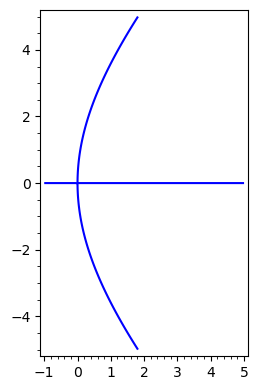

In [54]:
implicit_plot(local, (-1,5), (-5,5))

looks like a bifurcation to me

In [58]:
sols = [solve(local, theta0)[0].rhs(), out[0](theta0 = solve(local, theta0)[0].rhs())] # now solutions are spanned by lambda
        # theta0 = g(l)                 # theta1 = h(g(l), l)

lprint(sols) # now only in terms of lambda

$ \left[-\frac{3}{2} \, \sqrt{\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}}, \frac{11907}{31250} \, \sqrt{\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}} {\lambda}^{3} + \frac{20169}{1000000} \, {\left(\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}\right)}^{\frac{3}{2}} {\lambda} + \frac{567}{2500} \, \sqrt{\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}} {\lambda}^{2} - \frac{243}{20000} \, {\left(\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}\right)}^{\frac{3}{2}} + \frac{27}{200} \, \sqrt{\frac{9}{19} \, {\lambda}^{2} + \frac{100}{19} \, {\lambda}} {\lambda}\right] $

In [171]:
coords = { list(var_dict_old.keys())[i] : sols[i] for i in [0,1] }
coords
[tfuncs[i](**coords)(l = 0.01) for i in [0,1]] # see that we solve both equations

[9.77409948905484e-6, -7.65013934688049e-6]

However solutions are in the reformed space, needed to undo the action that reorganised the kernel

### Generating more solutions

We have solved $f \circ A$ where $A$ orthogonalised the kernel, thus by applying $A$ we can get a traversel of the new solutions.

In [113]:
lprint(A)

$ \left(\begin{array}{rr}
\frac{1}{5} & \frac{4}{5} \\
-\frac{2}{5} & \frac{2}{5}
\end{array}\right) $

In [145]:
fsols = list(A*vector(sols))
len(fsols)

2

In [141]:
#fsols = [random.random()/10000 for i in range(0,2)] # can check these are giving solutions

In [184]:
coords = { list(var_dict_old.keys())[i] : fsols[i] for i in [0,1] }
coords

{'theta0': 23814/78125*sqrt(9/19*l^2 + 100/19*l)*l^3 + 20169/1250000*(9/19*l^2 + 100/19*l)^(3/2)*l + 567/3125*sqrt(9/19*l^2 + 100/19*l)*l^2 - 243/25000*(9/19*l^2 + 100/19*l)^(3/2) + 27/250*sqrt(9/19*l^2 + 100/19*l)*l - 3/10*sqrt(9/19*l^2 + 100/19*l),
 'theta1': 11907/78125*sqrt(9/19*l^2 + 100/19*l)*l^3 + 20169/2500000*(9/19*l^2 + 100/19*l)^(3/2)*l + 567/6250*sqrt(9/19*l^2 + 100/19*l)*l^2 - 243/50000*(9/19*l^2 + 100/19*l)^(3/2) + 27/500*sqrt(9/19*l^2 + 100/19*l)*l + 3/5*sqrt(9/19*l^2 + 100/19*l)}

In [190]:
sym_funcs = [func.function(*list(var_dict_old.values()))(l = l + 2/3) for func in funcs] # convert to symbolic functions
# *** IF SOMETHING IS BREAKING CHECK THAT RIGHT SHIFT HERE ***

In [191]:
vector([float(func(**coords)(l = 0.01)) for func in sym_funcs])

(1.8414125957238038e-05, 2.833241134583418e-05)

We see that these solutions do indeed comprise a new set of solutions

In [194]:
for i in range(0,10):
    print(float(i/100), float(sols[0](l = i/100)), float(sols[1](l = i/100)))

0.0 0.0 0.0
0.01 -0.344278421599361 0.00017067869689780496
0.02 -0.48710206430750386 0.0005049807236962491
0.03 -0.5968436716771425 0.0009695137268265359
0.04 -0.6894849336165443 0.0015585200305396557
0.05 -0.7712131591473951 0.002272223899992609
0.06 -0.845200069743689 0.0031133976908829554
0.07 -0.9133289313506417 0.004086184611077317
0.08 -0.97682622491629 0.005195575550890395
0.09 -1.0365434715539201 0.006447139173567321
